In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

##transforms.ToTensor() : converts the image with pixel values from 0 to 255, into a PyTorch Tensor.
## transforms.Normalize :  mean and standard deviation to 0.5, Why? Neural networks tend to train faster and more stably when the input data is centered around zero.

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


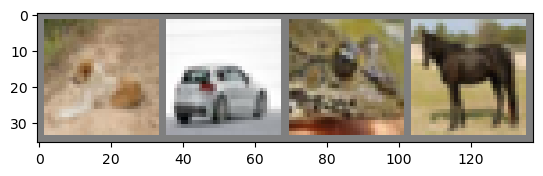

dog   car   frog  horse


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img/2+0.5 #normalize because matplotlib do not understand the tensor. This bring the range back to [0, 1] so that Matplotlib can display the colors correctly.
    npimg = img.numpy() #PyTorch tensor into a NumPy array. Matplotlib is designed to work with NumPy arrays, so this is a required step.
    plt.imshow(np.transpose(npimg, (1,2,0))) #PyTorch organizes image tensors in the format (Channels, Height, Width).#Matplotlib expects them in the format (Height, Width, Channels).np.transpose(npimg, (1, 2, 0)) rearranges the dimensions of the array.
    plt.show()

# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images

imshow(torchvision.utils.make_grid(images))

# print labels

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
## Now making neural network for this

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  

    def forward(self,x):
        # 2. Define the forward pass (how data flows through the layers)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten the image into a 1D vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # No activation function on the final layer for nn.CrossEntropyLoss
        return x

# Now, create an instance of your network
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Now Loss Function and Optimizer we are doing here.........

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data
         # 2. Zero the gradients to clear old results
        optimizer.zero_grad()
         # 3. Forward pass: Make a prediction
        outputs = net(inputs)
         # 4. Calculate the loss (the error)
        loss = criterion(outputs, labels)
         # 5. Backward pass: Calculate the gradients
        loss.backward()
         # 6. Update the weights
        optimizer.step()
         # Print statistics to monitor progress
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.166
[1,  4000] loss: 1.830
[1,  6000] loss: 1.661
[1,  8000] loss: 1.572
[1, 10000] loss: 1.497
[1, 12000] loss: 1.440
[2,  2000] loss: 1.396
[2,  4000] loss: 1.363
[2,  6000] loss: 1.347
[2,  8000] loss: 1.311
[2, 10000] loss: 1.304
[2, 12000] loss: 1.271
Finished Training


### The Final Step: Testing the Model 🏆

In [15]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Calculate outputs by running images through the network
        outputs = net(images)
        
        # The class with the highest score is what we choose as our prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [17]:
# Define a path to save the model
PATH = './cifar_net.pth'

# Save the model's learned parameters (its "brain")
torch.save(net.state_dict(), PATH)